# Imports

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from scipy.signal import savgol_filter
from scipy.optimize import minimize, curve_fit

import matplotlib.pyplot as plt
import seaborn as sns
import mpl_defaults


In [2]:
def groupby_savgol_filter(series:pd.Series, window_length, polyorder):
    '''
    Applys savitzky golay filtering to a 
    pandas series, with nan handling.
    Compatible with pd.groupby
    '''
    filtered_signal = savgol_filter(series.dropna().values, window_length, polyorder)
    filtered_series = series.copy()
    filtered_series[~filtered_series.isna()]=filtered_signal
    return filtered_series



# Background on viscosity probes in liquid helium-3

<font size = 4>

* $^3\text{He}$ is a quantum liquid at ultra low temperatures $T\approx 0.001$ K
* The observable properties in viscosity of a bath of $10^{18}$ $^3\text{He}$ atoms is often related to the microscopic, quantum mechanical properties.
* Quartz tuning forks (four of them imaged below) are used as viscometers in $^3\text{He}$.

<img src = 'images/tuning-fork.jpg' />


<font size = 4>

* These devices are made of quartz crystal, fabricated with metal electrodes.
* Quart's piezoelectric effect causes mechanical vibrations to induce an electrical voltage on the electrodes.
* I.e there is a one-to-one mapping between mechanical motion and electrical voltage.  Oscillations in the "tines" results in an oscillating electrical signal.

<font size = 4>

The equation of motion of the "tines" for the major axis of motion can be expressed as a linear second order differential equation:

<font size = 6>

$$
\frac{d^2x}{dt^2} + \frac{f_0}{Q} \frac{dx}{dt} + f_0^2 x(t) = k e^{i f_D t}
$$


<font size = 4>

* $f_0$ is the resonator's natural frequency.
* $Q$ quantifies how strong the vibrations are at resonance.

A general solution that satisfies this equation of motion can be expressed as 

<font size = 6>

$$
x(t) = Ae^{if_Dt}
$$.  

<font size = 4>

Where $A$ is complex and can be expressed as $A=X+iY$
<font size = 6>

$A(f_D) = k\frac{i Qf_0^2}{Q(f_0-f_D)^2 + if_0^2} $


$X(f_D) = \text{Re}(A)$

$Y(f_D) = \text{Im}(A)$

<font size = 4>

Which are all dependent of the frequency the fork is driven at, $f_D$.


* $X$ describes the vibrational mode that is in phase with the driving force.
* $Y$ describes the vibrational mode that is $180^\circ$ out of phase with the driving force.
* At $f_D =  f_0$ $X$ is maximized and $Y=0$.

I will load and fit some sample data to visualize the solution to the diff. equation.

<!-- The symmetric motion $X$ and oscillation amplitude is maximized when $f=f_0$, and the antisymmetric motion $Y$ is zero.    -->

## The ideal vibrational spectrum

Text(31050, 100, 'resonance\n$f=f_0$')

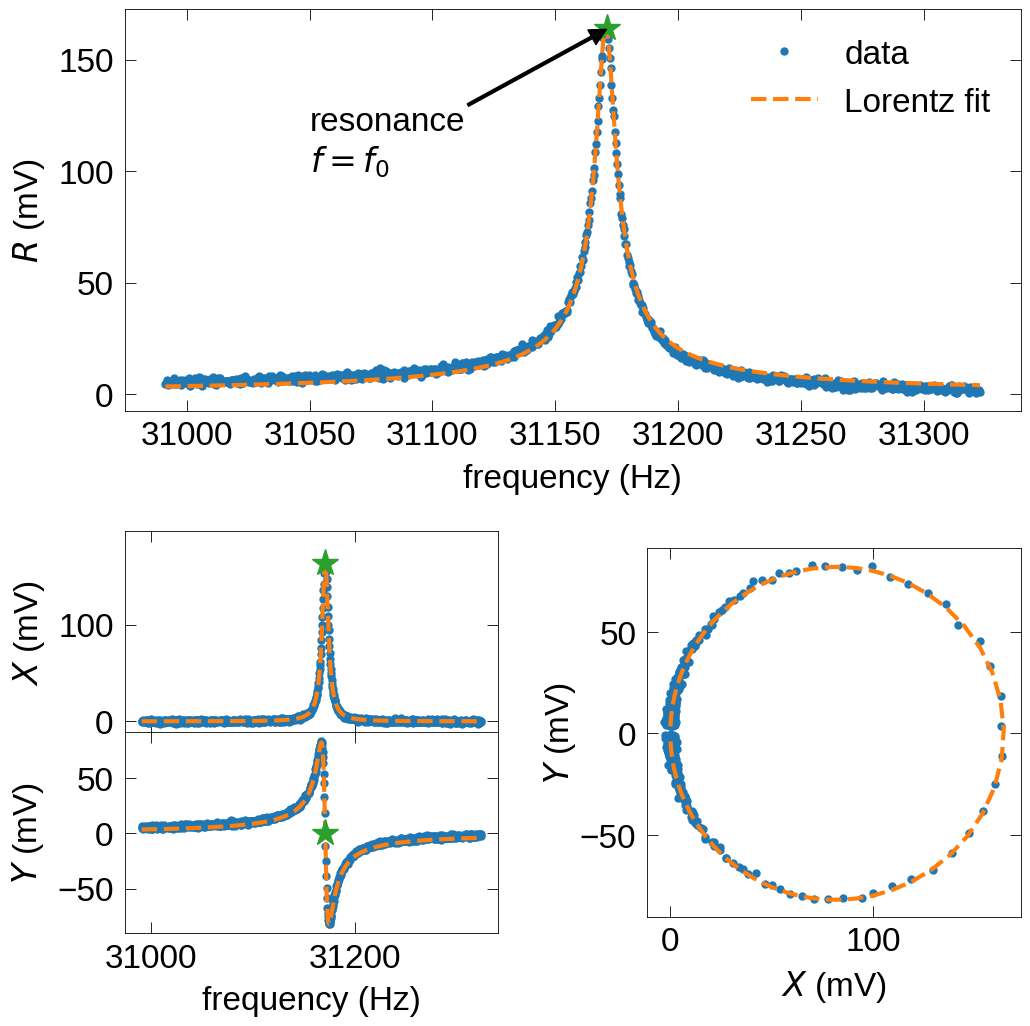

In [3]:
def rotation_matrix(angle):
    '''
    rotate two vectors
    angle should be input as degrees
    '''
    theta = angle/180*np.pi
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

dfQTF = pd.read_csv('resonator-data/resonator-response.txt', sep = ';')
dfQTF['X_raw'] = 1E9*dfQTF['Amplitude (V)']*np.cos(dfQTF['Phase (deg)']*np.pi/180)
dfQTF['Y_raw'] = 1e9*dfQTF['Amplitude (V)']*np.sin(dfQTF['Phase (deg)']*np.pi/180)
dfQTF[['X', 'Y']] = dfQTF[['X_raw', 'Y_raw']].dot(rotation_matrix(0.9)).values

dfQTF['A']=np.sqrt(np.diag((dfQTF[['X', 'Y']].dot(dfQTF[['X', 'Y']].T))))

def resonator_x(f, f0, delta_f0, A):
    complex_resp =  1j*delta_f0 * f0*A*( (f0**2 - f**2) + 1j*delta_f0*f )**-1
    return np.real(complex_resp)

def resonator_y(f, f0, delta_f0, A):
    complex_resp = 1j*f0*delta_f0*A*( (f0**2 - f**2) + 1j*delta_f0*f )**-1
    return np.imag(complex_resp)

p0 = [
    dfQTF.iloc[dfQTF.X.idxmax()]['Frequency (Hz)'],
    dfQTF.iloc[dfQTF.Y.idxmin()]['Frequency (Hz)']-dfQTF.iloc[dfQTF.Y.idxmax()]['Frequency (Hz)'], 
    dfQTF.X.max()
]

xParams, xCov =curve_fit(
    resonator_x, 
    dfQTF['Frequency (Hz)'], dfQTF['X'], 
    p0 = p0
)

yParams, yCov = curve_fit(
    resonator_y,
    dfQTF['Frequency (Hz)'], dfQTF['Y'],
    p0 = p0
)

dfQTF['X_fit']=resonator_x(dfQTF['Frequency (Hz)'], *xParams)
dfQTF['Y_fit']=resonator_y(dfQTF['Frequency (Hz)'], *yParams)

fig, [axa, axb, axc, axd] =mpl_defaults.lorentzian_plot(dfQTF, fcol='Frequency (Hz)')

#### ANNOTATIONS####

resonance_pt = dfQTF.loc[dfQTF.X==dfQTF.X.max()]
axa.plot(resonance_pt['Frequency (Hz)'], resonance_pt.A, '*', markersize = 20)
axb.plot(resonance_pt['Frequency (Hz)'], resonance_pt.X, '*', markersize = 20)
axc.plot(resonance_pt['Frequency (Hz)'], 0, '*', markersize = 20)

axb.set_ybound(upper = dfQTF.X.max()*1.2)
# axa.text(x = 31100, y = 125,s='resonance\n'+r'$f=f_0$', horizontalalignment = 'center')
arrow_props = {'width':2, 'color': 'k'}
axa.annotate(
    text = 'resonance\n'+r'$f=f_0$',
    xy = (resonance_pt['Frequency (Hz)'].iloc[0], dfQTF.X.max()),
    xytext = (31050, 100),
    arrowprops=arrow_props
)

## Background subtractions in practical operation

<font size = 4>

* The perfect Lorentzian spectrum is unachievable when operating the tuning fork at millikelvin temperatures in a cryostat.
* The transmission lines between electronics and the tuning fork at millikelvin temperatures contribute a substatinal background.
* The Lorentzian circle is deformed by the spectrum of the electrical transmission lines.

<img src='images/cryostat-background.jpg'>

## The data cleaning goal

<img src='images/raw-data-summary.jpg' />




<font size = 4>

* The above plot is the $Q$ of a quartz tuning fork versus temperature, when the fluid is at a pressure of 29.3 bar.
* Expected behavior is at $T=0$, $Q=0$ and $Q\propto T$.
* The intercept in figure (a) is erroneous and needs to be subtracted.
* The large jumps in figure (c) (blown up in the insets) are unphysical.
* The difference between the $T$ linear power law and the data has unphysical jumps.

* The goal is to remove the intercept to be consistent with established theory, and remove the jump discontinuities from the raw data. I will utilize `pd.groupby` to perform these corrections to $Q$ v.s. $T$ at multiple pressures.

# Import dataset

In [4]:
def chi_to_T(x, coeff = [ 7.35395434e-06, -2.90946673e-02,  1.85983869e-01,  4.04657918e-02]):
    '''
    Converts the voltage signal from the 
    magnetic temp to a temperature
    by approximating the inverse of a third
    order cubic polynomial.
    '''
    Tsamp = np.arange(20, 0.45, step=-0.1E-3)
    inv_Tsamp = Tsamp**-1
    chi_fit = np.polyval(coeff, inv_Tsamp)
    return np.interp(x, xp = chi_fit, fp = inv_Tsamp)**-1

def data_importer(base_filepath, temperature_datafile, fork_datafile, chi_norm_factor):
    '''
    Imports data on the properties of a quartz tuning fork
    immerse in liquid helium-3.  
    
    Chi_norm_factor is a detail related to the amplification
    setting on the electronics used to measure the temperature.
    '''
    
    fork_raw_data = pd.read_csv(base_filepath + fork_datafile)

    fork_columns = [
        '#[2]Universal Time',
        '#[3]X [ V ]',
        '#[4]Y [ V ]', 
        '#[5]Drive freq. [ Hz ]', 
        '#[6]Q', 
        '#[7]Inferred freq. [ Hz ]', 
        '#[11]k_eff', 
        '#[13]T_MCT [ mK ]'
    ]

    fork_data = fork_raw_data.loc[:, fork_columns].copy()
    fork_data.rename(
        {
            fork_columns[0]: 'fork_UTC', 
            fork_columns[1]:'X', 
            fork_columns[2]:'Y',
            fork_columns[3]:'f_drive', 
            fork_columns[4]:'Q', 
            fork_columns[5]:'f_0', 
            fork_columns[6]:'k', 
            fork_columns[7]:'T_mct'
        }, 
        axis =1, inplace=True)

    temp_raw_data = pd.read_csv(base_filepath + temperature_datafile) #temp for temperature
    temp_cols = ['UTC', 'Temperature', 'chi\'', 'chi\'\'']
    temp_data = temp_raw_data.loc[:, temp_cols].copy()
    
    temp_data.rename(
        {temp_cols[0]:'temp_UTC', temp_cols[1]:'T_raw', temp_cols[2]:'chi_real', temp_cols[3]:'chi_im'}, 
        axis = 1, inplace = True)
    
    temp_data['chi'] = 5*temp_data['chi_real']/chi_norm_factor
    temp_data['Temperature'] = chi_to_T(temp_data['chi'])
    
    # merge the temperature dataset with the fork dataset
    # use interpolation on the UTC timestamps to merge 
    # the temperature datafile into the fork datafile.
    merged_data = fork_data.copy()
    for merge_column in ['T_raw', 'chi', 'chi_im']:
        merged_data[merge_column] = np.interp(
            x=fork_data['fork_UTC'],
            xp=temp_data['temp_UTC'],
            fp=temp_data[merge_column])

    return merged_data



In [5]:
dataset = pd.DataFrame()
pressure_set = ['29bar new', '29bar', '27bar', '25bar', '23bar', '20bar', '15bar', '10bar', '8bar_new', '8bar_old', '5bar', '2bar', '0.5bar']

for pressure in pressure_set:
    basefilepath = 'sample-data/'
    
    if pressure == '29bar new' or pressure == '27bar' or pressure == '23bar':
      data_import = pd.read_csv(f'{basefilepath}{pressure}.csv')

    else:
      fork_file = '{} fork.csv'.format(pressure)
      temp_file = '{} lcmn.csv'.format(pressure)


      data_import = data_importer(basefilepath, temp_file, fork_file, chi_norm_factor=5).dropna()
    data_import['set'] = pressure
    dataset = pd.concat([dataset, data_import], axis = 0, ignore_index=True)
    
experiment_params=pd.read_csv('experiment_parameters.csv').set_index('Nominal P')
experiment_params.index.rename('set', inplace=True)

dataset=dataset.merge(experiment_params, on=['set'], how='left')
dataset = dataset.set_index(['P', 'set',  'fork_UTC']).sort_index().reset_index(level='P')
dataset['data_point']=dataset.groupby('set').cumcount()
dataset = dataset.reset_index(level='fork_UTC').set_index('data_point', append=True)
dataset['time_minutes']=dataset.groupby('set', group_keys=False).apply(lambda x: (x.fork_UTC - x.fork_UTC.min())/60)

/tmp/ipykernel_653385/3192966047.py:49: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_raw_data = pd.read_csv(base_filepath + temperature_datafile) #temp for temperature
/tmp/ipykernel_653385/3192966047.py:49: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_raw_data = pd.read_csv(base_filepath + temperature_datafile) #temp for temperature
/tmp/ipykernel_653385/3192966047.py:49: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_raw_data = pd.read_csv(base_filepath + temperature_datafile) #temp for temperature
/tmp/ipykernel_653385/3192966047.py:49: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_raw_data = pd.read_csv(base_filepath + temperature_datafile) #temp for temperature


* Error messages originate from unsused columns in this analysis, please ignore.

# Temperature outlier corrections
* Temperature outliers ocurr ocasionally, and does not reflect the true temperature of the sample.
* Outliers get replaced with a filtered temperature, but well behaved raw data is kept in the dataset.

In [6]:
def TemperatureSpikeCorrector(temperature_series:pd.Series, group_key='set', window_length=13, polyorder=1):
    '''
    Replaces outliers in the temperature with
    a time-averaged temperature reading,
    using a savitzky golay filter.
    '''
    smoothed_T = savgol_filter(temperature_series.values, window_length, polyorder)
    
    T_residual = smoothed_T - temperature_series
    z_scores = T_residual.groupby(group_key, group_keys=False).apply(zscore)
    z_scores = zscore(T_residual)
    outlier_selector = ~z_scores.between(-1, 1)
    
    temperature_clean = temperature_series.copy()
    temperature_clean[outlier_selector] = smoothed_T[outlier_selector]    

    output=pd.DataFrame(
        np.array([temperature_series.values, temperature_clean, T_residual, smoothed_T]).T,
        columns=['T_raw', 'T_clean', 'T_residual', 'T_smoothed'],
        index=temperature_clean.index
    )

    return output
temperature_corrections_df = dataset['T_raw'].groupby('set', group_keys=False).apply(TemperatureSpikeCorrector)
temperature_corrections_df['time_minutes']=dataset['time_minutes'].copy()

dataset['Temperature']=temperature_corrections_df['T_clean'].copy()
dataset['T/Tc-1'] = dataset['Temperature']/dataset['Tc'] -1
dataset = dataset.loc[dataset['T/Tc-1'].between(0, 2).copy()]

<Axes: xlabel='timestamp (minutes)', ylabel='residuals (mK)'>

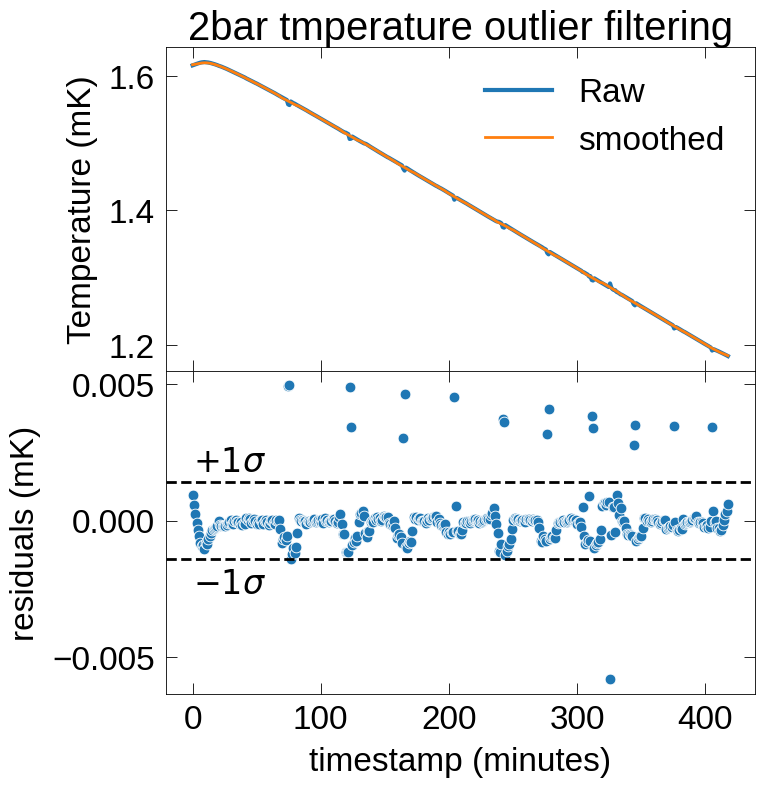

In [7]:
fig, ax = plt.subplots(2, 1, figsize = (9.2, 1.5*5.6), sharex=True)
fig.subplots_adjust(hspace=0)
axa, axb= ax
pressure='2bar'
axa.set_title(f'{pressure} tmperature outlier filtering')
args = {'data':temperature_corrections_df.loc[pressure], 'x':'time_minutes'}
sns.lineplot(**args, y = 'T_raw', ax=axa, linewidth = 3, label='Raw')
sns.lineplot(**args, y = 'T_smoothed', ax = axa, color ='tab:orange', 
            label='smoothed', linestyle='-', linewidth = 2)


mu, sigma = temperature_corrections_df.T_residual.mean(), temperature_corrections_df.T_residual.std()
axb.axhline(mu-1*sigma, color='k', linestyle='--')
axb.axhline(mu+1*sigma, color='k', linestyle='--')

axb.set_xlabel('timestamp (minutes)')

axa.set_ylabel('Temperature (mK)')
axb.set_ylabel('residuals (mK)')

axb.text(x=0, y =mu+sigma*1.3, s=r'$+1\sigma$')
axb.text(x=0, y =mu-sigma*1.9, s=r'$-1\sigma$')

sns.scatterplot(**args, y='T_residual', s=60)


* Temperature data points that lie outside a window of $\pm1$ standard deviation from the smoothed temperature are outliers.  
* Outliers get replaced with the smoothed temperature

# Q jump corrections

## Feature initialization
`_adj` denotes an adjusted feature

In [8]:
# INITIZALIZE all the features before corrections

def Q_calc(df, Xcol='X_adj', Ycol= 'Y_adj', kcol = 'k_adj'):
    '''
    Calculates Q-factor from X, Y, and k columns in a dataframe
    The returned value is a series of Q values.
    Args:
        df (pd.DataFrame): The dataframe to draw X, Y, and k from.
        Xcol (str): The column name for X.
        Ycol (str): The column name for Y.
        kcol (str): The column name for k.
    '''
    return 10*df[kcol] * (df[Xcol]**2 + df[Ycol]**2)/df[Xcol]

def f0_calc(df, Xcol='X_adj', Ycol = 'Y_adj', kcol='k_adj', fdrive_col='f_drive'):
    '''
    Calculates the resonance frequency 
    f0 from X, Y, k, and drive frequency 
    columns. The returned value is a series 
    of f0 values.
    Args:
        df (pd.DataFrame): The dataframe that contains the X, Y, k, and f_drive.
        Xcol (str): The column name for X.
        Ycol (str): The column name for Y.
        kcol (str): The column name for k.
        fdrive_col (str): The column name for f_drive.
    '''
    q = Q_calc(df, Xcol, Ycol, kcol)
    return df[fdrive_col]*(1+df[Ycol]/df[Xcol]*(2*q)**-1)

# define indicators for when the drive was
# reset, the last data point before a reset
# and the data point following a reset
dataset['drive_reset']=dataset['f_drive'].groupby('set', group_keys=False).diff().dropna() != 0
dataset['pre_drive_reset'] = dataset['drive_reset'].shift(-1)
dataset['post_drive_reset'] = dataset['drive_reset'].shift(1)
drive_reset_columns = ['drive_reset', 'pre_drive_reset', 'post_drive_reset']
for col in drive_reset_columns: 
    dataset.loc[dataset[col].isna(), col]=False
# dataset.loc[dataset[drive_reset_columns].isna(), drive_reset_columns]=False

dataset['X_adj']=dataset.X.copy()
dataset['Y_adj']=dataset.Y.copy()
dataset['k_adj']=dataset.k.copy()
dataset['Q_adj']=Q_calc(dataset)
dataset['f0_adj']=f0_calc(dataset)

dataset.loc['29bar new', 'show_figure']=True
dataset.loc['23bar', 'show_figure']=True

## Intercept subtraction

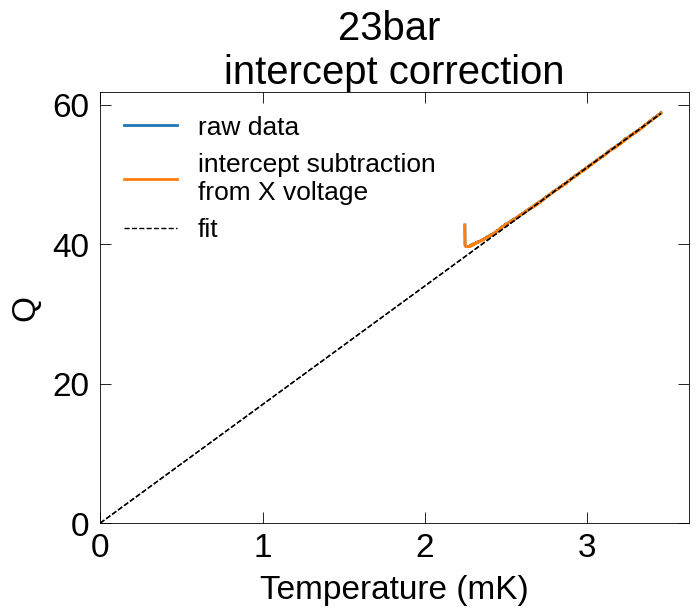

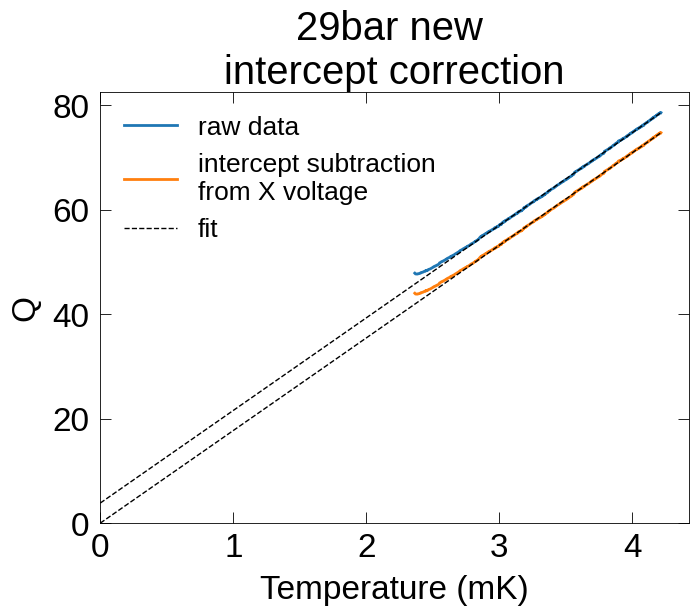

In [9]:
def X_interecept_subtract(df:pd.DataFrame, 
                          Tcol='Temperature', Qcol='Q_adj', 
                          Xcol='X_adj', kcol='k_adj',
                          figcol='show_figure'):
    '''
    Subtracts a value from that X that is 
    proportional to the line of best fit
    in Q versus temperature.
    This forces the intercept of the high 
    temperature fit to be zero.
    The returned value is a series of 
    X voltages and best fit line params.   

    '''
    Tc=df['Tc'].values[0]
    fitrange = df[Tcol].between(1.2*Tc, 2*Tc)
    xfit, yfit = df.loc[fitrange, [Tcol, Qcol]].values.T
    [m,b] = np.polyfit(xfit, yfit, deg = 1)

    output = pd.DataFrame(
        (df[Xcol])-b/(10*df[kcol]), 
        columns=['output_series'])
    output['Q_linear_fit'] = np.polyval([m, b], df[Tcol])
    output['dQ'] = df[Qcol] - output['Q_linear_fit']
    output[['m','b']] = [m,b]

    if df[figcol].any():
        fig, ax = plt.subplots(1, 1)
        axa = ax
        axa.plot(*df[[Tcol, Qcol]].values.T, label='raw data')
        axa.plot(df[Tcol], df[Qcol] - b, label='intercept subtraction\nfrom X voltage')
        
        axa.plot([0, xfit.max()], np.polyval([m, b], [0, xfit.max()]), 'k--', linewidth=1, label='fit')
        axa.plot([0, xfit.max()], np.polyval([m, 0], [0, xfit.max()]), 'k--', linewidth=1)
        axa.legend(fontsize=19)
        axa.set_xbound(lower=0)
        axa.set_ybound(lower=0)
        axa.set_xlabel('Temperature (mK)')
        axa.set_ylabel('Q')
        axa.set_title(df.index.get_level_values('set').unique()[0] + ' \nintercept correction')

    return output

dataset['X_adj']=dataset.groupby('set', group_keys=False).apply(X_interecept_subtract)['output_series']

# recalculate Q_adj and f0_adj
dataset['Q_adj']=Q_calc(dataset)
dataset['f0_adj']=f0_calc(dataset)
dataset['f0_intercept_subtract'] = dataset['f0_adj'].copy()

## Consequential error in the resonance $f_0$ temperature dependence

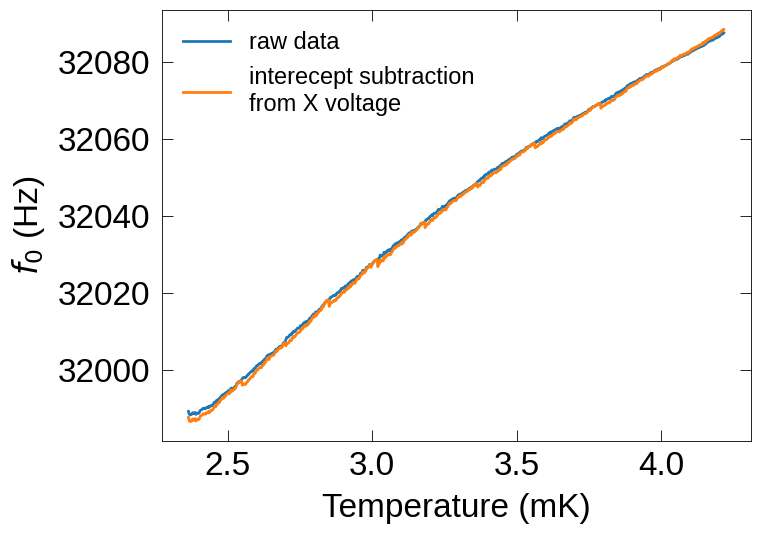

In [10]:
fig, axc = plt.subplots(1, 1, figsize=(9.2, 5.6))
data=dataset.loc['29bar new']
axc.plot(data.Temperature, data.f_0, label = 'raw data')
axc.plot(data.Temperature, data.f0_intercept_subtract, 
         label = 'interecept subtraction\nfrom X voltage')

axc.set_xlabel('Temperature (mK)')
axc.set_ylabel(r'$f_0$ (Hz)')
axc.legend(fontsize = 17)

<font size = 4>

* Subtracting a constant value from $X$ causes erroneus jumps in $f_0$ versus temperature.
* Jump errors in $f_0$ can be corrected from adjusting the $k$ constant.  

## k constant adjustment

* Find the optimal $k$ constant that minimizes the jumps.

In [11]:
def k_adjuster(df:pd.DataFrame, reset_col='drive_reset', 
               Xcol='X_adj', Ycol='Y_adj', 
               kcol='k_adj',fdrive_col='f_drive',  
               figcol='show_figure'):
    '''
    Adjusts the k constant by 
    minimizing the error from jumps in the f0 at drive reset locations.
    The function that is minimized is f0_jump_calc.
    The returned value is a dimensionless constant, 
    typically between 1<x<2.
    The new k constant would be k_new = x*k_old 
    See example dataset for more clarification.

    Args:
        df (pd.DataFrame): The dataframe that contains the X, Y, k, and f_drive.
        resetloc: The dataframe indices of where drive resets occur.
        Xcol (str): The column name for X.
        Ycol (str): The column name for Y.
        kcol (str): The column name for k.
        fdrive_col (str): The column name for f_drive.
    '''
    results = minimize(minimize_f0_jump_calc, 1.1, method='Nelder-Mead', 
                       args = (df, reset_col, Xcol, Ycol, kcol, fdrive_col))
    output = pd.DataFrame(
        [results]
    )
    output = pd.DataFrame(
        df[kcol].droplevel(0)
    )
    output['k_adj_factor']=results.x[0]
    output['minimized_fval'] = results.fun
    output['output_k_adj']=results.x[0]*output[kcol]
    return output


def minimize_f0_jump_calc(x, df:pd.DataFrame, reset_col='drive_reset', Xcol='X_adj', Ycol='Y_adj', kcol='k_adj', fdrive_col='f_drive'):
    '''
    Calculates the difference between the f0 at a drive reset, 
    and the f0 immediately after the reset.
    The returned value is the sum of the squared differences.

    Args:
        df (pd.DataFrame): The dataframe that contains the X, Y, k, and f_drive.
        resetloc: The dataframe indices of where drive resets occur.
        Xcol (str): The column name for X.
        Ycol (str): The column name for Y.
        kcol (str): The column name for k.
        fdrive_col (str): The column name for f_drive.

    '''
    Q_value = x*Q_calc(df, Xcol, Ycol, kcol)
    f0_value = df[fdrive_col]*(1 +  (2*Q_value)**-1*df[Ycol]/df[Xcol])
    reset_indices = df.loc[df[reset_col]].index
    pre_reset_indices = df.loc[df['pre_'+reset_col]].index

    f0_errors = f0_value.loc[reset_indices].values - f0_value.loc[pre_reset_indices].values
    f0_err = np.dot(f0_errors, f0_errors) 
    return f0_err

# def f0_jump_calc(df:pd.DataFrame, x, reset_col='drive_reset', Xcol='X_adj', Ycol='Y_adj', kcol='k_adj', fdrive_col='f_drive'):
#     return minimize_f0_jump_calc(x, df, reset_col, Xcol, Ycol, kcol, fdrive_col)

dataset['k_adj']=dataset.groupby('set', group_keys=True).apply(k_adjuster)['output_k_adj']
dataset['Q_adj']=Q_calc(dataset)
dataset['f0_adj']=f0_calc(dataset)

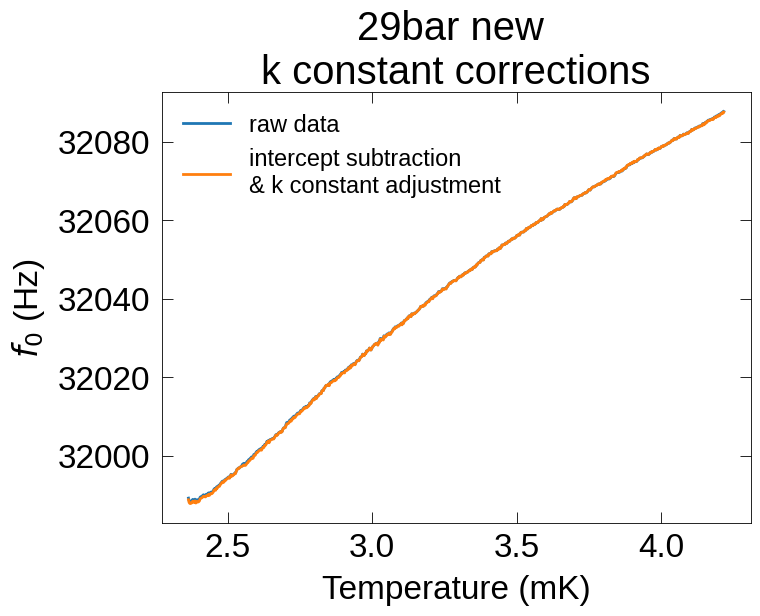

In [12]:
fig, axd = plt.subplots(1, 1, figsize = (9.2, 5.6))
pressure='29bar new'
data=dataset.loc[pressure]

axd.set_title(f'{pressure} \nk constant corrections')
axd.plot(data.Temperature, data.f_0, label='raw data')
axd.plot(data.Temperature, data.f0_adj, label='intercept subtraction\n& k constant adjustment')


axd.set_xlabel('Temperature (mK)')
axd.set_ylabel(r'$f_0$ (Hz)')
axd.legend(fontsize=17)

## Background subtraction from $(X, Y)$

In [13]:
def circle_parametric(theta, xcenter, ycenter, Diam):
    '''
    Equation of a circle.  
    For a given theta this will return the x and y values of a circle.

    Args:
      theta: The angles, measured from the center, to generate x and y arrays
      xcenter: The x center position
      ycenter: The y center position
      Diam: The diameter of the circle
    '''
    x_arr = Diam/2 * np.cos(theta) + xcenter
    y_arr = Diam/2 * np.sin(theta) + ycenter
    return x_arr, y_arr

def XY_error_calc(df:pd.DataFrame, resetcol='drive_reset',
                 Xcol='X_adj', Ycol='Y_adj', kcol='k_adj', 
                 f0_col='f0_adj', fdrive_col='f_drive'
                 ):
    
    '''
    Calculates how much the $X, Y$ response is off
    from what resonator equations would predict.
    This assumes the resonance frequency and Q-factor has not changed 
    over the course of a reset.

    Args:
        df (pd.DataFrame): The dataset.
        resetcol (array): The column for where resets are located.
        Xcol (str): The column name for X.
        Ycol (str): The column name for Y.
    '''

    reset_df=df.loc[df[resetcol]].copy()    
    pre_reset_df=df.loc[df['pre_'+resetcol]].copy()
    # post_reset_df=df.loc[df['post_'+resetcol]].copy()
    adjustment_columns = ['x_shift', 'y_shift', 'x_error', 'y_error']
    
    if len(reset_df)==0:
        df[adjustment_columns]=0
        return df[adjustment_columns]
    
    nyquist_diameter = pre_reset_df.T.apply(
        lambda x: x[Xcol] + x[Ycol]**2/x[Xcol]
    ).values

    nyquist_x_center = nyquist_diameter/2
    nyquist_y_center = 0


    reset_df['f_drive_final/f0_initial']=reset_df[fdrive_col].values/pre_reset_df[f0_col].values
    
    target_ypt = 2 * 10*reset_df[kcol] * (reset_df['f_drive_final/f0_initial']**-1 - 1) * (reset_df[Xcol].values)**2
    reset_df['lorentz_theta']=np.arctan(
        target_ypt/reset_df[Xcol].values)


    x_trajectory, y_trajectory = circle_parametric(
        theta = 0,
        xcenter=nyquist_x_center,
        ycenter=nyquist_y_center,
        Diam=nyquist_diameter
    )

    reset_df['x_shift']=(x_trajectory - reset_df[Xcol].values)
    reset_df['y_shift']=(y_trajectory - reset_df[Ycol].values)

    reset_df[['x_error', 'y_error']] = reset_df[['x_shift', 'y_shift']].cumsum()

    df.loc[reset_df.index, adjustment_columns] =reset_df[adjustment_columns].copy()
    df[adjustment_columns[2:]] = df[adjustment_columns[2:]].ffill()
    df[adjustment_columns[2:]] = df[adjustment_columns[2:]].fillna(0)
    output = df[adjustment_columns]

    return output


dataset[['x_shift', 'y_shift', 'x_error', 'y_error']]=dataset.groupby('set', group_keys=False).apply(XY_error_calc)
dataset['X_adj_final']=dataset['X_adj'] + dataset['x_error']
dataset['Y_adj_final']=dataset['Y_adj'] + dataset['y_error']

final_cols ={'Xcol':'X_adj_final', 'Ycol':'Y_adj_final'}
dataset['Q_adj']=Q_calc(dataset, **final_cols)
dataset['f0_adj']=f0_calc(dataset, **final_cols)



A figure that summarizes these corrections:

<img src='images/XY-adjustments.jpg' />

<font size = 4>



<span style="color:red">The correction procedure shown above is a bit too technically involved, feel free to skip this part.  A comparision of the raw data and the cleaned data will be made below in the conclusion of the notebook.</span>

* As the temperature evolves, the $X$ and $Y$ voltages change.
* The $Q$ and $f_0$ are inferred from the $X$ and the $Y$.
* At the points where $Y$ versus $X$ jumps, the driving frequency has been reset.
* Before and after a reset, the $Q$ and $f_0$ should be the same (within the noise scale of the experiment.)
* The blue data is the raw data
    * The start of a reset is marked as an orange star
    * The dashed lines represents the trajectory of $(X, Y)$ if the $Q$ and $f_0$ were to be unchanged during a reset.
    * The trajectory (green circle) does not intersect with the blue data points
    * This is the origin of the jumps in Q!  
* The orange data corrects for these small offsets in the data by subtracting the appropriate vector from the data.
    * Now the data intersects the trajectory after a drive reset.

# Final comparison of the raw data to cleaned data

In [14]:
def linear_fit(df:pd.DataFrame, Tcol='Temperature', Qcol='Q_adj'):
    '''
    Fits a line to Q versus temperature at high temperatures.  
    Returns the linear fit and the difference between the fit
    and the data.
    '''
    Tc=df['Tc'].values[0]
    fitrange = df[Tcol].between(1.2*Tc, 2*Tc)
    xfit, yfit = df.loc[fitrange, [Tcol, Qcol]].values.T
    [m,b] = np.polyfit(xfit, yfit, deg = 1)    
    
    yhat = np.polyval([m,b], df[Tcol])
    delta_Q = df[Qcol] - yhat 
    output = pd.DataFrame(
        np.array([yhat, delta_Q]).T,
        columns=['Q_linear_fit', 'dQ'],
        index = df.index
    )

    return output
dataset[['Q_linear_fit_raw', 'dQ_raw']]=dataset.groupby('set', group_keys=False).apply(linear_fit, Qcol='Q').values
dataset[['Q_linear_fit_adj', 'dQ_adj']]=dataset.groupby('set', group_keys=False).apply(linear_fit, Qcol='Q_adj').values

In [15]:
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset, InsetPosition
import matplotlib as mpl

def extrap_to_0(x, y):
    coeff=np.polyfit(x, y, deg=1)
    xhat = np.linspace(0, x.max())
    return xhat, np.polyval(coeff, xhat)

Text(0.5, 1.0, '$^3$He pressurized at 29.3 bar')

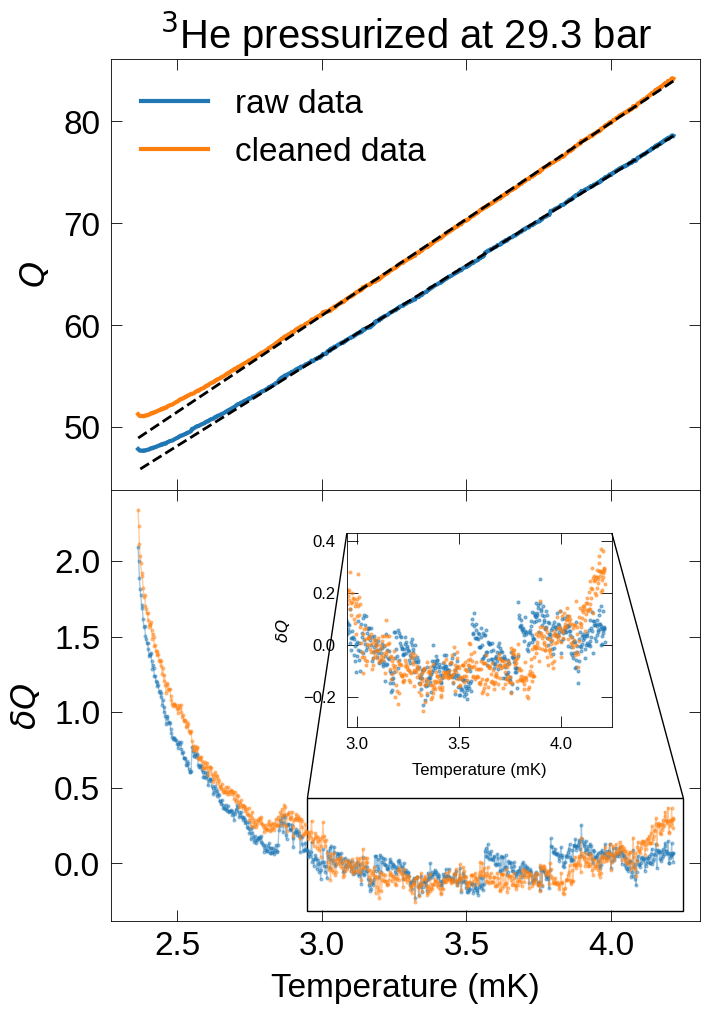

In [16]:
fig = plt.figure(figsize = (9.2, 5.6*2))
gs = GridSpec(nrows = 2, ncols = 1 )
axa = fig.add_subplot(gs[0])
axb = fig.add_subplot(gs[1])
fig.subplots_adjust(hspace = 0)

pressure='29bar new'
df = dataset.loc[pressure]

data_plot_params = {'linewidth': 3}
fit_plot_params = {'linewidth': 2, 'color': 'k', 'linestyle': '--'}
axa.plot(df['Temperature'], df['Q'], label='raw data', **data_plot_params)
axa.plot(df['Temperature'], df['Q_linear_fit_raw'], **fit_plot_params)


axa.plot(df['Temperature'], df['Q_adj'],  label='cleaned data', **data_plot_params)
axa.plot(df['Temperature'], df['Q_linear_fit_adj'], **fit_plot_params)

axb.plot(df['Temperature'], df['dQ_raw'], 'o-', alpha=0.4, linewidth =1)
axb.plot(df['Temperature'], df['dQ_adj'], 'o-', alpha=0.4, linewidth =1)

axa.legend()

axc.plot(df['Temperature'], df['Q'], **data_plot_params)
# axc.plot(df['Temperature'], df['Q_linear_fit_raw'], **fit_plot_params)
axc.plot(
    *extrap_to_0(*df[['Temperature', 'Q_linear_fit_raw']].values.T),
    **fit_plot_params)

axc.plot(df['Temperature'], df['Q_adj'], **data_plot_params)
# axc.plot(df['Temperature'], df['Q_linear_fit_adj'], **fit_plot_params)
axc.plot(
    *extrap_to_0(*df[['Temperature', 'Q_linear_fit_adj']].values.T),
    **fit_plot_params)


axb.set_xlabel('Temperature (mK)')
axa.set_ylabel(r'$Q$')
axb.set_ylabel(r'$\delta Q$')

axc.set_xlabel('Temperature (mK)')
axc.set_ylabel(r'$Q$')
axc.set_xbound(lower=0)
mpl_defaults.autoscale_y(axc)





iaxb = plt.axes([0, 0, 1,1])
ipb = InsetPosition(axb, [0.4, 0.45, 0.45 ,0.45])
iaxb.set_axes_locator(ipb)
mark_inset(axb, iaxb, loc1= 2, loc2 = 1)
iaxb.plot(df['Temperature'], df['dQ_raw'], 'o', alpha=0.5, linewidth = 1)
iaxb.plot(df['Temperature'], df['dQ_adj'], 'o', alpha=0.5, linewidth = 1)

iaxb.set_xlim(2.95, 4.25)
mpl_defaults.autoscale_y(iaxb)
iaxb.tick_params(labelsize = 12)
iaxb.set_xlabel('Temperature (mK)', fontsize = 12)
iaxb.set_ylabel(r'$\delta Q$' , fontsize = 12)



axa.set_title(r'$^3$He pressurized at 29.3 bar')    

* The cleaning process has remoed the jumps in the Q
* Although they are second order changes in $Q$ versus temperature, they make substatinal changes in $\delta Q$ versus temperature.
* The bottom plot is the difference between the linear fits and the data, and is the key discovery in the paper.
* The maximum in $\delta Q$ is an important pressure dependent quantity that is a central topic in the article.
